In [4]:
# Import dependancies
import requests
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
import joblib
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

In [ ]:
# All dependencies below were used originally but have since been commented out and could be used in the future (if we had more time)

# from sklearn.datasets import make_classification
# from keras.models import load_model
# import keras
# from sqlalchemy import create_engine, Column, Integer, String, Float
# from sqlalchemy.ext.declarative import declarative_base

In [2]:
# Create an API request using the link provided by asterank to gather data
url = "http://asterank.com/api/asterank?query=" 
response = requests.get(url + '{"price":{"$lt":1, "$gt":0}}&limit=1000').json()
# Data retrieval is limited to 1000 rows by default and can not be changed (by design)

# Create dataframe using data retrieved by the request above
df = pd.DataFrame(response)
df = df.sort_values(by = 'price' , ascending = False)

In [3]:
# Second request to get more data into the final dataframe
response2 = requests.get(url + '{"price":{"$gt":1}}&limit=1000').json()
df2 = pd.DataFrame(response2)

In [4]:
# Using only colummns we felt were necessary for our project
neo_df = df[['full_name', 'spec' , 'class' , 'ad' , 'q' , 'a' , 'e' , 'dv' ,'per' , 'price' , 'profit' , 'moid' , 'diameter']]
neo_df2 = df2[['full_name', 'spec' , 'class' , 'ad' , 'q' , 'a' , 'e' , 'dv' ,'per' , 'price' , 'profit' , 'moid' , 'diameter']]
neo_df2

,full_name,spec,class,ad,q,a,e,dv,per,price,profit,moid,diameter
0,(2002 AT4),D,AMO,2.700043,1.033903,1.866973,0.446214,5.557219,931.763080,1.599387e+03,3.344928e+02,0.042987,
1,(2001 SG286),D,APO,1.829700,0.886638,1.358169,0.347181,5.640122,578.134644,2.420770e+03,4.868816e+02,0.005336,
2,(2001 YE1),T,APO,2.870736,0.954085,1.912410,0.501109,5.905332,965.984260,1.450130e+04,2.547227e+03,0.059394,
3,(2001 UU92),T,AMO,5.287454,1.053954,3.170704,0.667596,7.286746,2062.205995,3.814231e+04,4.300143e+03,0.118818,
4,96 Aegle,T,MBA,3.479834,2.621945,3.050889,0.140597,NaN,1946.427065,6.196000e+04,3.981251e+03,1.641370,177.774
...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,372 Palma (1893 AH),B,MBA,3.966001,2.334280,3.150141,0.258992,11.987880,2042.176736,4.065526e+18,2.615080e+17,1.446870,173.642
992,423 Diotima (1896 DB),C,MBA,3.176470,2.956412,3.066441,0.035882,11.224330,1961.328629,4.235026e+18,2.908848e+17,1.942490,175.859
993,702 Alauda (1910 KQ),B,MBA,3.247375,3.137278,3.192327,0.017244,12.757615,2083.336507,5.408989e+18,3.264933e+17,2.120800,190.98
994,334 Chicago (1892 L),C,OMB,3.981728,3.798870,3.890299,0.023502,11.703702,2802.676341,6.115258e+18,4.009727e+17,2.782950,198.77


## Headers

spec = spectral type

ad = aphelion distance (AU)

q = perihelion (AU)

a = semi-major axis (AU) => (longest diameter from its obit)

e = eccentricity

dv = delta-velocity

per = period => (how long for 1 revolution around the sun)

moid = minimum orbit intersection distance

In [5]:
# Merging both datasets by appending
merged_df = neo_df.append(neo_df2)
merged_df

,full_name,spec,class,ad,q,a,e,dv,per,price,profit,moid,diameter
797,532 Herculina (1904 NY),S,MBA,3.258720,2.286373,2.772546,0.175353,10.733275,1686.229234,8.378840e-37,6.035861e-38,1.35440,167.791
796,354 Eleonora (1893 A),Sl,MBA,3.117824,2.479441,2.798633,0.114053,11.416972,1710.083231,5.863736e-37,3.967666e-38,1.49290,148.97
795,471 Papagena (1901 GN),S,MBA,3.555410,2.232245,2.893827,0.228619,10.449882,1798.072857,5.764868e-37,4.264148e-38,1.26726,148.128
794,349 Dembowska (1892 T),R,MBA,3.190289,2.654931,2.922610,0.091589,10.493194,1824.965628,4.843060e-37,3.564270e-38,1.65738,139.77
793,40 Harmonia,S,MBA,2.373855,2.160638,2.267247,0.047021,NaN,1246.942831,2.442248e-37,1.579404e-38,1.16159,111.251
...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,372 Palma (1893 AH),B,MBA,3.966001,2.334280,3.150141,0.258992,11.987880,2042.176736,4.065526e+18,2.615080e+17,1.44687,173.642
992,423 Diotima (1896 DB),C,MBA,3.176470,2.956412,3.066441,0.035882,11.224330,1961.328629,4.235026e+18,2.908848e+17,1.94249,175.859
993,702 Alauda (1910 KQ),B,MBA,3.247375,3.137278,3.192327,0.017244,12.757615,2083.336507,5.408989e+18,3.264933e+17,2.12080,190.98
994,334 Chicago (1892 L),C,OMB,3.981728,3.798870,3.890299,0.023502,11.703702,2802.676341,6.115258e+18,4.009727e+17,2.78295,198.77


In [6]:
# Replacing empty cells with 'nan' to be able to drop eaier later
new_df = merged_df.replace('', np.nan, inplace=False)
new_df

,full_name,spec,class,ad,q,a,e,dv,per,price,profit,moid,diameter
797,532 Herculina (1904 NY),S,MBA,3.258720,2.286373,2.772546,0.175353,10.733275,1686.229234,8.378840e-37,6.035861e-38,1.35440,167.791
796,354 Eleonora (1893 A),Sl,MBA,3.117824,2.479441,2.798633,0.114053,11.416972,1710.083231,5.863736e-37,3.967666e-38,1.49290,148.97
795,471 Papagena (1901 GN),S,MBA,3.555410,2.232245,2.893827,0.228619,10.449882,1798.072857,5.764868e-37,4.264148e-38,1.26726,148.128
794,349 Dembowska (1892 T),R,MBA,3.190289,2.654931,2.922610,0.091589,10.493194,1824.965628,4.843060e-37,3.564270e-38,1.65738,139.77
793,40 Harmonia,S,MBA,2.373855,2.160638,2.267247,0.047021,NaN,1246.942831,2.442248e-37,1.579404e-38,1.16159,111.251
...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,372 Palma (1893 AH),B,MBA,3.966001,2.334280,3.150141,0.258992,11.987880,2042.176736,4.065526e+18,2.615080e+17,1.44687,173.642
992,423 Diotima (1896 DB),C,MBA,3.176470,2.956412,3.066441,0.035882,11.224330,1961.328629,4.235026e+18,2.908848e+17,1.94249,175.859
993,702 Alauda (1910 KQ),B,MBA,3.247375,3.137278,3.192327,0.017244,12.757615,2083.336507,5.408989e+18,3.264933e+17,2.12080,190.98
994,334 Chicago (1892 L),C,OMB,3.981728,3.798870,3.890299,0.023502,11.703702,2802.676341,6.115258e+18,4.009727e+17,2.78295,198.77


In [7]:
# Dropping all null values
new_df = new_df.dropna()
new_df

,full_name,spec,class,ad,q,a,e,dv,per,price,profit,moid,diameter
797,532 Herculina (1904 NY),S,MBA,3.258720,2.286373,2.772546,0.175353,10.733275,1686.229234,8.378840e-37,6.035861e-38,1.35440,167.791
796,354 Eleonora (1893 A),Sl,MBA,3.117824,2.479441,2.798633,0.114053,11.416972,1710.083231,5.863736e-37,3.967666e-38,1.49290,148.97
795,471 Papagena (1901 GN),S,MBA,3.555410,2.232245,2.893827,0.228619,10.449882,1798.072857,5.764868e-37,4.264148e-38,1.26726,148.128
794,349 Dembowska (1892 T),R,MBA,3.190289,2.654931,2.922610,0.091589,10.493194,1824.965628,4.843060e-37,3.564270e-38,1.65738,139.77
791,674 Rachele (1908 EP),S,MBA,3.493765,2.351323,2.922544,0.195453,10.483907,1824.903811,1.577649e-37,1.162629e-38,1.38596,96.171
...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,372 Palma (1893 AH),B,MBA,3.966001,2.334280,3.150141,0.258992,11.987880,2042.176736,4.065526e+18,2.615080e+17,1.44687,173.642
992,423 Diotima (1896 DB),C,MBA,3.176470,2.956412,3.066441,0.035882,11.224330,1961.328629,4.235026e+18,2.908848e+17,1.94249,175.859
993,702 Alauda (1910 KQ),B,MBA,3.247375,3.137278,3.192327,0.017244,12.757615,2083.336507,5.408989e+18,3.264933e+17,2.12080,190.98
994,334 Chicago (1892 L),C,OMB,3.981728,3.798870,3.890299,0.023502,11.703702,2802.676341,6.115258e+18,4.009727e+17,2.78295,198.77


Median profit = 0
<br> 1 = profitable
<br> 0 = not profitable

In [8]:
# Creating a row with 0 and 1 as values to be able to run machine learning models using this data
new_df['profitable'] = (new_df['profit'] > 1).astype(int)
new_df['diameter'] = new_df['diameter'].astype(float)

# Outputting to csv for heroku deployment
new_df.to_csv('resources/asteroid_data.csv', header = True)

C:\Users\Robert\AppData\Local\Temp/ipykernel_4508/2390934984.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['profitable'] = (new_df['profit'] > 1).astype(int)
C:\Users\Robert\AppData\Local\Temp/ipykernel_4508/2390934984.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['diameter'] = new_df['diameter'].astype(float)


# Supervised Machine Learning

In [9]:
# Dropping non-beneficial columns
X = new_df.drop(['full_name','profit','price','spec', 'class','profitable'], axis =1)
y = new_df['profitable']

## Key Takeaway

Dropped profit and price assuming we don't already know that information about a newly discovered asteroid. Dropped spectral type since we are very unlikely to know the spectral type for a new asteroid. "The overwhelming majority of asteroids have no spectral classification and are missing other important data attributes." (asterank.com) Dropped class because class is determined by the other features. 

In [10]:
# Converting categorical data into a numeric format
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Scaling the data for best results
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Training a Random Forest Classifier model and printing the score
clf_for = RandomForestClassifier(random_state=1, n_estimators=100).fit(X_train_scaled, y_train)

print(f'Training Score: {clf_for.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf_for.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 0.8167202572347267


model 1 (RandomForest) ==> Good accuracy scores, not overfitting

In [12]:
# Creating new x_train and y_train variables based on different data
sel = SelectFromModel(clf_for)
sel.fit(X_train_scaled, y_train)

SelectFromModel(estimator=RandomForestClassifier(random_state=1))

In [13]:
# Training a Logistic Regression model and printing the score
clf_log = LogisticRegression().fit(X_train_scaled, y_train)

print(f'Training Score: {clf_log.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf_log.score(X_test_scaled, y_test)}')

Training Score: 0.7392703862660944
Testing Score: 0.7395498392282959


In [14]:
# Scaling and transforming new variables based on different data
X_selected_train, X_selected_test, y_train, y_test = train_test_split(sel.transform(X), y, random_state=1)
scaler = StandardScaler().fit(X_selected_train)

X_selected_train_scaled = scaler.transform(X_selected_train)
X_selected_test_scaled = scaler.transform(X_selected_test)

In [15]:
# Training a Logistic Regression with different selected data and printing the results
clf_log_sel = LogisticRegression().fit(X_selected_train_scaled, y_train)

print(f'Training Score: {clf_log_sel.score(X_selected_train_scaled, y_train)}')
print(f'Testing Score: {clf_log_sel.score(X_selected_test_scaled, y_test)}')

Training Score: 0.7639484978540773
Testing Score: 0.7363344051446945


model 2 (Logistic Regression) ==> decent accuracy, but training score is a bit low

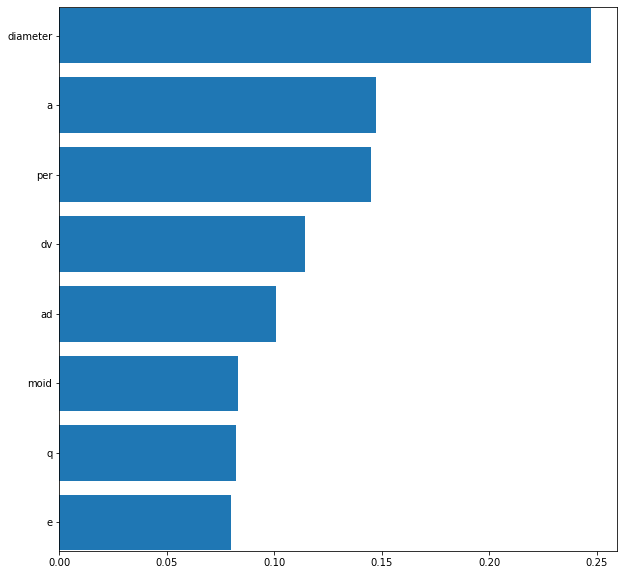

In [16]:
# Checking to see which features were most important to drop features that primarily added noise
feature_importances = clf_for.feature_importances_
features = sorted(zip(X.columns, clf_for.feature_importances_), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]


# Creating the graph to visualize the feature importance
fig, ax = plt.subplots()

fig.set_size_inches(10,10)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

In [17]:
# Saving the Random Forest Classifier Model
joblib.dump(clf_for,"ml_models/rf_model.joblib")

['ml_models/rf_model.joblib']

In [18]:
# Saving the Logistic Regression (Selected) Model
joblib.dump(clf_log_sel,"ml_models/log_sel_model.joblib")

['ml_models/log_sel_model.joblib']

In [19]:
# Saving the Logistic Regression Model
joblib.dump(clf_log,"ml_models/log_model.joblib")

['ml_models/log_model.joblib']

# Unsupervised Machine Learning

In [20]:
# Finding which columns have null values
for column in new_df.columns:
    print(f"Column {column} has {new_df[column].isnull().sum()} null values")

Column full_name has 0 null values
Column spec has 0 null values
Column class has 0 null values
Column ad has 0 null values
Column q has 0 null values
Column a has 0 null values
Column e has 0 null values
Column dv has 0 null values
Column per has 0 null values
Column price has 0 null values
Column profit has 0 null values
Column moid has 0 null values
Column diameter has 0 null values
Column profitable has 0 null values


In [21]:
# Drop non beneficial columns
unsup_df = new_df.drop(['full_name'], axis = 1)
unsup_df

,spec,class,ad,q,a,e,dv,per,price,profit,moid,diameter,profitable
797,S,MBA,3.258720,2.286373,2.772546,0.175353,10.733275,1686.229234,8.378840e-37,6.035861e-38,1.35440,167.791,0
796,Sl,MBA,3.117824,2.479441,2.798633,0.114053,11.416972,1710.083231,5.863736e-37,3.967666e-38,1.49290,148.970,0
795,S,MBA,3.555410,2.232245,2.893827,0.228619,10.449882,1798.072857,5.764868e-37,4.264148e-38,1.26726,148.128,0
794,R,MBA,3.190289,2.654931,2.922610,0.091589,10.493194,1824.965628,4.843060e-37,3.564270e-38,1.65738,139.770,0
791,S,MBA,3.493765,2.351323,2.922544,0.195453,10.483907,1824.903811,1.577649e-37,1.162629e-38,1.38596,96.171,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,B,MBA,3.966001,2.334280,3.150141,0.258992,11.987880,2042.176736,4.065526e+18,2.615080e+17,1.44687,173.642,1
992,C,MBA,3.176470,2.956412,3.066441,0.035882,11.224330,1961.328629,4.235026e+18,2.908848e+17,1.94249,175.859,1
993,B,MBA,3.247375,3.137278,3.192327,0.017244,12.757615,2083.336507,5.408989e+18,3.264933e+17,2.12080,190.980,1
994,C,OMB,3.981728,3.798870,3.890299,0.023502,11.703702,2802.676341,6.115258e+18,4.009727e+17,2.78295,198.770,1


In [22]:
# Convert the features into numeric values
X = pd.get_dummies(unsup_df, columns=['spec' , 'class'])
X.columns

Index(['ad', 'q', 'a', 'e', 'dv', 'per', 'price', 'profit', 'moid', 'diameter',
       'profitable', 'spec_B', 'spec_C', 'spec_Cb', 'spec_Cg', 'spec_Cgh',
       'spec_Ch', 'spec_D', 'spec_K', 'spec_L', 'spec_Ld', 'spec_M', 'spec_O',
       'spec_P', 'spec_Q', 'spec_R', 'spec_S', 'spec_S(IV)', 'spec_Sa',
       'spec_Sk', 'spec_Sl', 'spec_Sq', 'spec_Sr', 'spec_T', 'spec_V',
       'spec_X', 'spec_Xc', 'spec_Xe', 'spec_Xk', 'class_AMO', 'class_APO',
       'class_ATE', 'class_CEN', 'class_IMB', 'class_MBA', 'class_MCA',
       'class_OMB', 'class_TJN'],
      dtype='object')

In [23]:
# Scale the data
ss = StandardScaler()
scaled_df = ss.fit_transform(X)

In [24]:
# Number of features
len(X.columns)

48

In [25]:
# Preserve 90% of the explained variance in dimensionality reduction.
pca = PCA(n_components = .9)

df_pca = pca.fit_transform(scaled_df)
df_pca

array([[ 0.85532065, -0.60779213, -0.09017344, ..., -0.12299554,
        -0.1753985 ,  0.16013711],
       [ 1.11627148, -0.99290541, -0.07166358, ...,  0.11159401,
         0.51392085, -0.0972596 ],
       [ 0.75507806, -0.34623272, -0.27340846, ..., -0.05227688,
        -0.20107371,  0.14349404],
       ...,
       [ 5.06430977, -0.89331496,  8.90179227, ..., -0.64723499,
        -1.41869487, -0.42331175],
       [ 7.55177945,  1.28814174, 10.1910681 , ..., -0.41199132,
        -0.32599791, -0.48589035],
       [ 8.7102583 , -0.20974846, 25.46032313, ..., -1.67690067,
        -1.81765967, -1.78180758]])

In [26]:
# Convert your data into a dataframe
space_df = pd.DataFrame(df_pca)
space_df

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.855321,-0.607792,-0.090173,1.490674,-1.023165,0.422395,-0.077770,0.067561,0.365553,-0.673035,...,0.095446,-0.138858,0.100827,-0.022101,0.075259,-0.175553,-0.207772,-0.122996,-0.175399,0.160137
1,1.116271,-0.992905,-0.071664,0.827393,-1.039860,0.226017,0.307701,-0.298303,-0.497872,1.855553,...,-0.377584,-0.438344,0.183003,0.059268,-0.276354,-0.267932,0.107740,0.111594,0.513921,-0.097260
2,0.755078,-0.346233,-0.273408,1.589878,-0.691966,0.350081,-0.090086,0.102894,0.326595,-0.676528,...,0.066238,-0.120473,0.073115,-0.026012,0.072025,-0.138970,-0.224425,-0.052277,-0.201074,0.143494
3,1.432733,-1.447863,-0.257890,0.815684,-1.179178,0.837364,-0.158793,0.123043,0.631487,2.224316,...,3.570831,-0.280943,2.158894,1.185254,13.639544,0.694266,4.510393,5.999101,0.431736,-0.015922
4,0.545310,-0.538649,-0.735416,1.441234,-0.598229,0.342086,-0.023011,0.182585,0.317117,-0.612322,...,0.037407,-0.069860,0.037043,-0.017789,0.048181,-0.086396,-0.204226,-0.074404,-0.191827,0.153470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1238,3.626935,0.292106,7.336541,3.858272,-1.063263,0.982015,0.783601,0.164923,-0.048290,-1.561175,...,0.207774,-0.001231,-0.219660,-0.113007,-0.117420,-0.648729,-0.645569,-0.225796,-1.370424,-0.259839
1239,4.259967,-1.065389,8.008626,4.338579,-1.982294,0.353211,0.648577,-0.869794,-0.013348,0.242797,...,0.347143,-0.155938,0.172488,0.022902,-0.104130,-0.708271,-0.074799,-0.402542,-0.062412,-0.253905
1240,5.064310,-0.893315,8.901792,4.762056,-2.427077,1.207191,1.116815,0.101638,0.010453,-1.419571,...,0.527886,-0.091225,-0.076648,-0.066151,-0.217858,-1.144956,-0.643982,-0.647235,-1.418695,-0.423312
1241,7.551779,1.288142,10.191068,5.759176,-4.921834,-1.216699,-0.238201,0.212576,-0.292513,0.507296,...,0.692671,-0.244635,0.264256,0.063217,-0.286629,-1.370654,-0.046723,-0.411991,-0.325998,-0.485890


In [27]:
# Display the explained variance
print(pca.explained_variance_ratio_)
print("------------------------------------------------------------------")
print("  ")

# New number of features after reducing and printing finding
new_feat = len(space_df.columns)
print(f" The amount of features went from 48 to {new_feat} after perserving 90% of the explained variance in dimensionality reduction")

[0.13641836 0.05681886 0.05282183 0.03963178 0.03431055 0.02822908
 0.02801053 0.02564107 0.02546647 0.02386721 0.02340111 0.02268858
 0.02218514 0.02186093 0.02171782 0.02159198 0.021527   0.02140469
 0.02136994 0.02129599 0.02117984 0.02115418 0.02111645 0.02109826
 0.02105587 0.02098259 0.02095029 0.02081045 0.02060827 0.02022927
 0.01896114 0.0172628 ]
------------------------------------------------------------------
  
 The amount of features went from 48 to 32 after perserving 90% of the explained variance in dimensionality reduction


In [28]:
# Further reduce the dataset dimensions with t-SNE
tsne = TSNE(learning_rate = 20)
tsne_feat = tsne.fit_transform(space_df)
tsne_feat

array([[-16.403702 , -14.613025 ],
       [-50.866657 ,  -4.2839174],
       [-16.358593 , -14.539437 ],
       ...,
       [ 29.142529 , -10.271959 ],
       [ 28.571943 , -10.986473 ],
       [ 29.024233 , -11.094461 ]], dtype=float32)

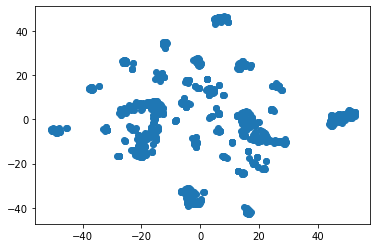

These clusters are from the class feature and spectral type feature that help to identify asteroids


In [29]:
# Visually inspect the results
space_df["x"] = tsne_feat[:,0]
space_df["y"] = tsne_feat[:,1]

# Plot 
plt.scatter(space_df["x"] , space_df["y"])
plt.savefig("images/clustered_scatter.PNG")
plt.show()
print('These clusters are from the class feature and spectral type feature that help to identify asteroids')

## Key Takeaway

Like in our unsupervised models, we need to have some kind of identifier present in our model or else we will be unable to effectively be able to categorize the asteroids in our data. This means that we must include either 'class' or 'spec' as an identifier for there to be significant findings with our data.

C:\Users\Robert\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


    k       inertia
0   1  1.150341e+06
1   2  6.844332e+05
2   3  4.769485e+05
3   4  3.330430e+05
4   5  2.653246e+05
5   6  2.233819e+05
6   7  1.972588e+05
7   8  1.678329e+05
8   9  1.505438e+05
9  10  1.280245e+05


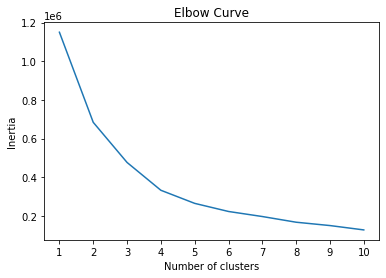

In [30]:
# Create the cluster analysis with k means
inertia = []
k = list(range(1 , 11))

# Calculate the inertia for the selected range of k values
for i in k:
    km = KMeans(n_clusters = i, random_state = 42)
    km.fit(space_df)
    inertia.append(km.inertia_)

# Create the elbow curve
elbow_data = {"k":k , "inertia": inertia}
elbow_df = pd.DataFrame(elbow_data)
print(elbow_df)
plt.plot(elbow_df['k'], elbow_df['inertia'])
plt.xticks(range(1,11))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.savefig("images/elbow_curve.PNG")
plt.show()

We already knew that asteroids were grouped by class and spec, but by using this model it showed us and confirmed that we cannot remove features that help identify since all other numeric features are too close for our models to differentiate between different asteroids based on quantifiable features alone.

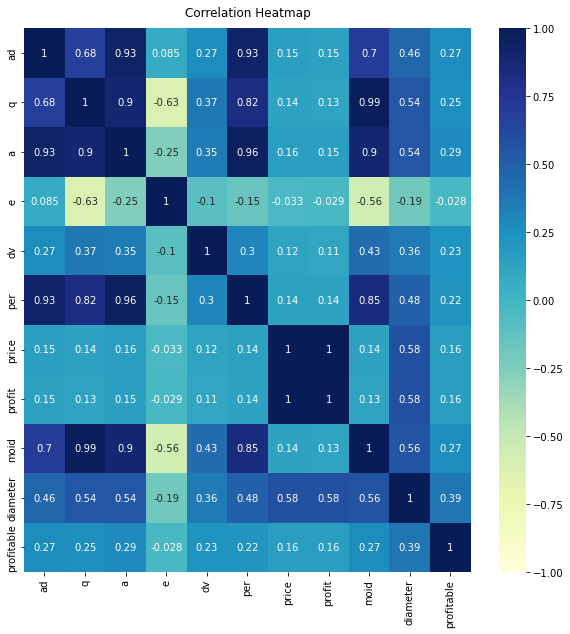

In [32]:
plt.figure(figsize=(10,10))
heat_map = sns.heatmap(data = unsup_df.corr(), vmin=-1, vmax=1, annot=True, cmap = "YlGnBu")
heat_map.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.savefig("images/heat_map.PNG")
plt.show()

Based on this heatmap above we can see there that some of the strongest correlation for profitability based on the figure is diameter. However, based on the machine learning models we know that the exclusion of spectral type (due to it being non numeric in nature) doesnt truly portray what influences profitability the most.

# Deep Learning

In [33]:
# Drop non-beneficial columns
deep_df = new_df.drop(['full_name','spec','class'],axis=1)
deep_df

,ad,q,a,e,dv,per,price,profit,moid,diameter,profitable
797,3.258720,2.286373,2.772546,0.175353,10.733275,1686.229234,8.378840e-37,6.035861e-38,1.35440,167.791,0
796,3.117824,2.479441,2.798633,0.114053,11.416972,1710.083231,5.863736e-37,3.967666e-38,1.49290,148.970,0
795,3.555410,2.232245,2.893827,0.228619,10.449882,1798.072857,5.764868e-37,4.264148e-38,1.26726,148.128,0
794,3.190289,2.654931,2.922610,0.091589,10.493194,1824.965628,4.843060e-37,3.564270e-38,1.65738,139.770,0
791,3.493765,2.351323,2.922544,0.195453,10.483907,1824.903811,1.577649e-37,1.162629e-38,1.38596,96.171,0
...,...,...,...,...,...,...,...,...,...,...,...
991,3.966001,2.334280,3.150141,0.258992,11.987880,2042.176736,4.065526e+18,2.615080e+17,1.44687,173.642,1
992,3.176470,2.956412,3.066441,0.035882,11.224330,1961.328629,4.235026e+18,2.908848e+17,1.94249,175.859,1
993,3.247375,3.137278,3.192327,0.017244,12.757615,2083.336507,5.408989e+18,3.264933e+17,2.12080,190.980,1
994,3.981728,3.798870,3.890299,0.023502,11.703702,2802.676341,6.115258e+18,4.009727e+17,2.78295,198.770,1


In [34]:
# Determine the number of unique values in each column
deep_df.nunique(axis=0)

ad            1243
q             1243
a             1243
e             1243
dv            1243
per           1243
price         1232
profit        1243
moid          1241
diameter      1211
profitable       2
dtype: int64

#### Left this section in to show previous binning and optimization -------------------------------------------------------------------------------------------------------------

In [35]:
# Check spec column for binning
# deep_df['spec'].value_counts()

In [36]:
# # Grabbing the bottom 3 values and throwing them all into a single value 'other'
# spec_to_replace = ['O','R','S(IV)']

# # Replace in dataframe
# for spec in spec_to_replace:
#     deep_df['spec'] = deep_df['spec'].replace(spec,'Other')

# # Make sure binning was successful
# deep_df['spec'].value_counts()

In [37]:
# # Check class column for binning
# deep_df['class'].value_counts()

In [38]:
# # Grabbing the bottom 2 values and throwing them all into a single value 'other'
# class_to_replace = ['CEN','IMB']

# # Replace in dataframe
# for clas in class_to_replace:
#     deep_df['class'] = deep_df['class'].replace(clas,'Other')

# # Make sure binning was successful
# deep_df['class'].value_counts()

#### The main takeaway is that we were able to score an accuracy of over 80% without the use of identifying characteristics (which most asteroids don't have anyways)

#### Actual code used in Nueral Network continued below ------------------------------------------------------------------------------------------------------------

In [39]:
# Create our dummy variables
dummy = pd.get_dummies(deep_df)
dummy

,ad,q,a,e,dv,per,price,profit,moid,diameter,profitable
797,3.258720,2.286373,2.772546,0.175353,10.733275,1686.229234,8.378840e-37,6.035861e-38,1.35440,167.791,0
796,3.117824,2.479441,2.798633,0.114053,11.416972,1710.083231,5.863736e-37,3.967666e-38,1.49290,148.970,0
795,3.555410,2.232245,2.893827,0.228619,10.449882,1798.072857,5.764868e-37,4.264148e-38,1.26726,148.128,0
794,3.190289,2.654931,2.922610,0.091589,10.493194,1824.965628,4.843060e-37,3.564270e-38,1.65738,139.770,0
791,3.493765,2.351323,2.922544,0.195453,10.483907,1824.903811,1.577649e-37,1.162629e-38,1.38596,96.171,0
...,...,...,...,...,...,...,...,...,...,...,...
991,3.966001,2.334280,3.150141,0.258992,11.987880,2042.176736,4.065526e+18,2.615080e+17,1.44687,173.642,1
992,3.176470,2.956412,3.066441,0.035882,11.224330,1961.328629,4.235026e+18,2.908848e+17,1.94249,175.859,1
993,3.247375,3.137278,3.192327,0.017244,12.757615,2083.336507,5.408989e+18,3.264933e+17,2.12080,190.980,1
994,3.981728,3.798870,3.890299,0.023502,11.703702,2802.676341,6.115258e+18,4.009727e+17,2.78295,198.770,1


In [40]:
# Split our preprocessed data into our features and target arrays
X = dummy.drop(['profitable', 'profit', 'price'],axis=1).values
y = dummy['profitable'].values
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [41]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [42]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
num_features = len(X_train_scaled[0])
hidden_node1 = 200
hidden_node2 = 400
hidden_node3 = 30
hidden_node4 = 4

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_node1, input_dim=num_features, activation='relu'))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_node2, activation='relu'))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_node3, activation='sigmoid'))

# Fourth hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_node4, activation='sigmoid'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               1800      
                                                                 
 dense_1 (Dense)             (None, 400)               80400     
                                                                 
 dense_2 (Dense)             (None, 30)                12030     
                                                                 
 dense_3 (Dense)             (None, 4)                 124       
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 94,359
Trainable params: 94,359
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Compile the model
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs = 220)

Epoch 1/220
30/30 [==============================] - 1s 3ms/step - loss: 0.7851 - accuracy: 0.4378
Epoch 2/220
30/30 [==============================] - 0s 3ms/step - loss: 0.6635 - accuracy: 0.6652
Epoch 3/220
30/30 [==============================] - 0s 3ms/step - loss: 0.6358 - accuracy: 0.7114
Epoch 4/220
30/30 [==============================] - 0s 3ms/step - loss: 0.6172 - accuracy: 0.7178
Epoch 5/220
30/30 [==============================] - 0s 3ms/step - loss: 0.6026 - accuracy: 0.7307
Epoch 6/220
30/30 [==============================] - 0s 2ms/step - loss: 0.5787 - accuracy: 0.7672
Epoch 7/220
30/30 [==============================] - 0s 3ms/step - loss: 0.5632 - accuracy: 0.7758
Epoch 8/220
30/30 [==============================] - 0s 2ms/step - loss: 0.5628 - accuracy: 0.7693
Epoch 9/220
30/30 [==============================] - 0s 2ms/step - loss: 0.5493 - accuracy: 0.7693
Epoch 10/220
30/30 [==============================] - 0s 2ms/step - loss: 0.5326 - accuracy: 0.7800
Epoch 11/

30/30 [==============================] - 0s 2ms/step - loss: 0.3909 - accuracy: 0.8530
Epoch 84/220
30/30 [==============================] - 0s 2ms/step - loss: 0.3777 - accuracy: 0.8509
Epoch 85/220
30/30 [==============================] - 0s 2ms/step - loss: 0.3841 - accuracy: 0.8498
Epoch 86/220
30/30 [==============================] - 0s 2ms/step - loss: 0.3880 - accuracy: 0.8509
Epoch 87/220
30/30 [==============================] - 0s 2ms/step - loss: 0.3757 - accuracy: 0.8584
Epoch 88/220
30/30 [==============================] - 0s 2ms/step - loss: 0.3798 - accuracy: 0.8530
Epoch 89/220
30/30 [==============================] - 0s 2ms/step - loss: 0.3845 - accuracy: 0.8487
Epoch 90/220
30/30 [==============================] - 0s 2ms/step - loss: 0.3798 - accuracy: 0.8594
Epoch 91/220
30/30 [==============================] - 0s 2ms/step - loss: 0.3808 - accuracy: 0.8530
Epoch 92/220
30/30 [==============================] - 0s 2ms/step - loss: 0.3736 - accuracy: 0.8573
Epoch 93/220


In [45]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

10/10 - 0s - loss: 0.5242 - accuracy: 0.7942 - 306ms/epoch - 31ms/step
Loss: 0.5242396593093872, Accuracy: 0.7942122220993042


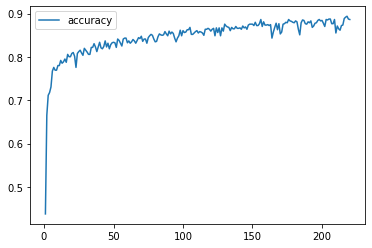

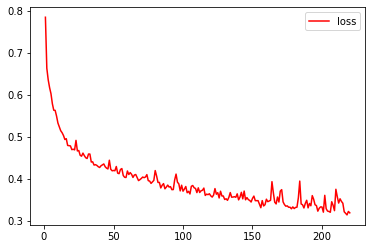

In [46]:
# Export our model to HDF5 file
history_df = pd.DataFrame(fit_model.history)
history_df.to_hdf('ml_models/asteroid_optimizer2.h5','df')

# Plot the accuracy and loss of the model
history_df.index += 1
fig_acc = history_df.plot(y="accuracy")
fig_loss = history_df.plot(y="loss", color='red')
fig_acc.figure.savefig("images/acc_plot.PNG")
fig_loss.figure.savefig("images/loss_plot.PNG")

In [48]:

# model = keras.models.load_model('ml_models/asteroid_optimizer2.h5')
# # model = tf.keras.Sequential([  tf.keras.layers.InputLayer(input_shape=(1,0)),  tf.keras.layers.Dense(1) ])
# test = model.predict(X_train_scaled)
rf_model = joblib.load("ml_models/rf_model.joblib")
url = "http://asterank.com/api/asterank?query=" 
num = 100
response = requests.get(url + '{"dv":{"$gt":0}}&limit=' + str(num)).json()
#print(response[0]['profit'])
asteroid_test = scaler.transform(np.array([response[0]['ad'],
                        response[0]['q'], 
                        response[0]['a'], 
                        response[0]['e'], 
                        response[0]['dv'], 
                        response[0]['per'], 
                        response[0]['moid'], 
                        response[0]['diameter']]).reshape(1,-1))

for n in range(1,num):
    asteroid_test2 = np.array([response[n]['ad'],
                        response[n]['q'], 
                        response[n]['a'], 
                        response[n]['e'], 
                        response[n]['dv'], 
                        response[n]['per'], 
                        response[n]['moid'], 
                        response[n]['diameter']]).reshape(1,-1)
    asteroid_test = np.append(asteroid_test, scaler.transform(asteroid_test2),0)
#print(asteroid_test)
test = rf_model.predict(asteroid_test)
num_accurate = 0
for n in range(num):
    print(response[n]['profit'])
    print(test[n])
    if (test[n] == 0 and response[n]['profit']<1) or (test[n] == 1 and response[n]['profit']>1):
        print('accurate')
        num_accurate +=1
    else:
        print('inaccurate')
    print("--------------------")
print(str((num_accurate/num)*100)+'% accurate')
test

0.0
0
accurate
--------------------
0.0
1
inaccurate
--------------------
4.009726636201235e+17
1
accurate
--------------------
6.098118873175501e+16
1
accurate
--------------------
3508416732592722.0
1
accurate
--------------------
2970964107966854.0
1
accurate
--------------------
1225833553622499.0
1
accurate
--------------------
9558192263144616.0
1
accurate
--------------------
0.0
1
inaccurate
--------------------
0.0
0
accurate
--------------------
1.4167917335365866e+16
1
accurate
--------------------
0.0
0
accurate
--------------------
1.1600737340443323e+17
1
accurate
--------------------
5.685843248528844e+16
1
accurate
--------------------
8.613990133034493e-39
0
accurate
--------------------
3131980065066220.0
1
accurate
--------------------
5332177740950569.0
1
accurate
--------------------
3.564269855597584e-38
0
accurate
--------------------
1.0079323465097085e+17
1
accurate
--------------------
0.0
1
inaccurate
--------------------
3.157723853785721e-40
0
accurate
----

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

We attempted to put our nueral network intoproduction but ran into issues regarding where the 'keras.load' function was pulling the model from (the wrong ram section) and since our Random Forest Classifier was running a similar score without any identifying features we decided to use that model instead.

## If we had more time (below)

In [49]:
# inputs = [{'Aphelion Distance':'input_1',
# 'Perihelion':'input_2',
# 'Semi-Major Axis':'input_3',
# 'Eccentricity':'input_4',
# 'Delta Velocity':'input_5',
# 'Period':'input_6',
# 'Minimum Orbit Intersection Distance':'input_7', 
# 'Diameter':'input_8',}]

In [50]:
# Base = declarative_base()

In [51]:
# conn = sqlite3.connect("Development_2/astroid_db.sqlite")

# cur = conn.cursor()

# for row in cur.execute('SELECT * FROM Model;'):
#     print(row)

# # con.close()
# database_path = "Development_2/astroid_db.sqlite"
# engine = create_engine(f"sqlite:///{database_path}")

In [3]:
# data = engine.execute("SELECT * FROM astroids")
# for i in data:
#     print(i)

In [ ]:
# session = Session(engine)

In [ ]:
# class Asteroids(Base):
#     __tablename__ = 'asteroids'
#     id = Column(Integer, primary_key=True)
#     ad = Column(Float)
#     q = Column(Float)
#     a = Column(Float)
#     e = Column(Float)
#     dv = Column(Float)
#     per = Column(Float)
#     moid = Column(Float)
#     diameter = Column(Float)

In [ ]:
# Base.metadata.tables

In [ ]:
# Base.metadata.create_all(engine)

In [ ]:
# data = engine.execute("SELECT * FROM asteroids")
# for i in data:
#     print(i)